In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error

C:\Users\karth\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
#Loading the data
df = pd.read_csv('./data/hourly_bookings.csv')
df.columns = ['Date', 'orders_booked']
df['Date'] = pd.to_datetime(df['Date'])

print(df.shape)
print(df.columns)
display(df.head(3))
display(df.tail(3))

(4416, 2)
Index(['Date', 'orders_booked'], dtype='object')


,Date,orders_booked
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71


,Date,orders_booked
4413,2018-08-31 21:00:00,159
4414,2018-08-31 22:00:00,223
4415,2018-08-31 23:00:00,205


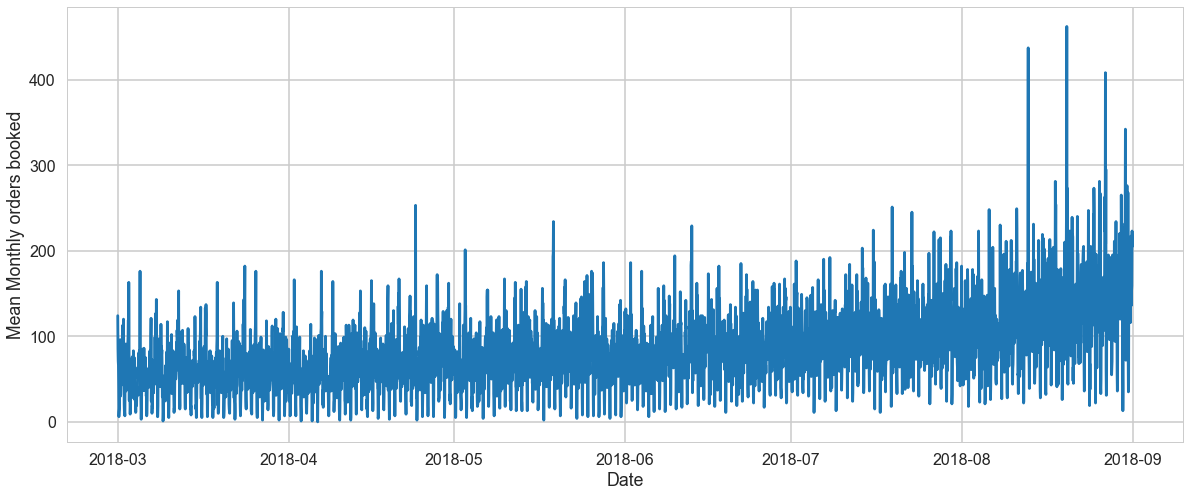

In [5]:
#Plotting the data
plt.figure(figsize=(20,8))
plt.style.use('seaborn-poster')
plt.style.use('seaborn-whitegrid')
plt.plot(df['Date'], df['orders_booked']); 
plt.xlabel('Date');
plt.ylabel('Mean Monthly orders booked');

# using the last 10% of the data as the test set

In [6]:
#Train test split
df_train = df.loc[0:3973]
df_train = df_train.reset_index(drop=True)
df_test = df.loc[3973:4415]
df_test = df_test.reset_index(drop=True)
print(df.shape, df_train.shape, df_test.shape)

(4416, 2) (3974, 2) (443, 2)


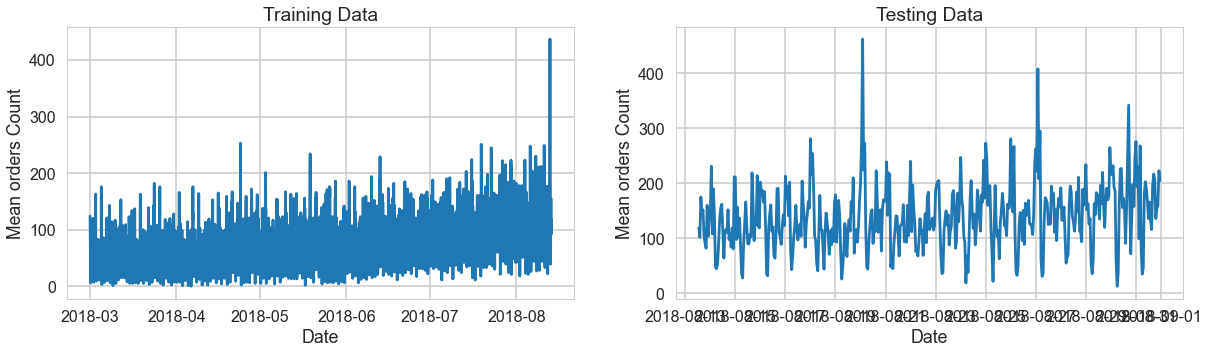

In [7]:
#Train Test data plot
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(df_train['Date'], df_train['orders_booked'])
plt.xlabel('Date')
plt.ylabel('Mean orders Count')
plt.title('Training Data')

plt.subplot(1,2,2)
plt.plot(df_test['Date'], df_test['orders_booked'])
plt.xlabel('Date')
plt.ylabel('Mean orders Count')
plt.title('Testing Data');

##  Dataset Creation for supervised models
This function is used from Jason Brownlee timeseries forecasting materials (https://machinelearningmastery.com/) to transform the time series data into a dataset that a machine learning regression model can be trained on.

In [8]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Selecting the lags
We use the previous 24 i.e hourly booking of the previous observations to predict the next order  booking. The approximate pattern will repeat every 24 hours.

In [10]:
data_train = series_to_supervised(df_train['orders_booked'].to_list(), 24, 1)
data_test = series_to_supervised(df_test['orders_booked'].to_list(), 24, 1)
print(data_train.shape, data_test.shape)

(3950, 25) (419, 25)


In [11]:
df_train_y = data_train['var1(t)']
df_train_X = data_train.drop(columns=['var1(t)'])
df_test_y = data_test['var1(t)']
df_test_X = data_test.drop(columns=['var1(t)'])

X_train = df_train_X.values
y_train = df_train_y.values
X_test = df_test_X.values
y_test = df_test_y.values

In [12]:
X_test

array([[119., 102., 175., ..., 155., 162., 114.],
       [102., 175., 144., ..., 162., 114.,  64.],
       [175., 144., 152., ..., 114.,  64., 112.],
       ...,
       [198., 158., 246., ..., 207., 136., 154.],
       [158., 246., 276., ..., 136., 154., 159.],
       [246., 276., 194., ..., 154., 159., 223.]])

In [13]:
df_test_X.head(3)
df_test_X.columns

Index(['var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)', 'var1(t-20)',
       'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)', 'var1(t-15)',
       'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)'],
      dtype='object')

In [18]:
# hyperparameters
N_ESTIMATORS = 100
MAX_DEPTH = 5

# create model
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

# train model
mid_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5)

In [19]:
# model evaluation

predictions = pd.DataFrame(y_test)
y_pred = mid_model.predict(X_test)
predictions['pred'] = y_pred
predictions.head()

,0,mid
0,64,123.978467
1,112,87.007257
2,116,125.870774
3,111,138.142163
4,152,140.404471


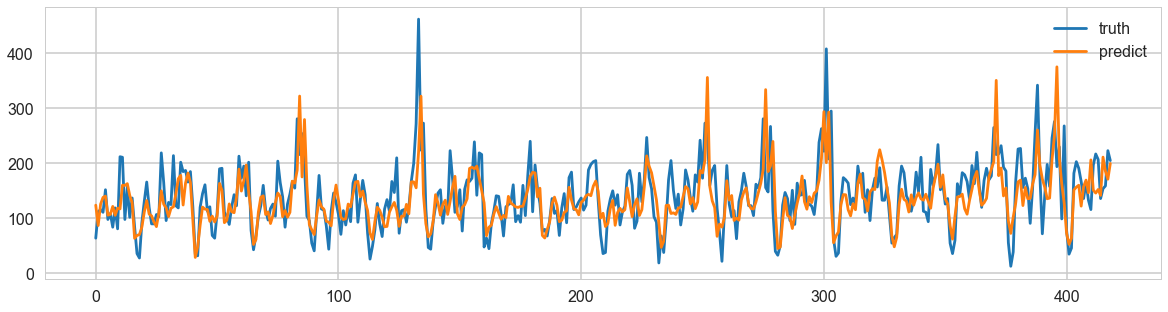

In [20]:
plt.figure(figsize=(20,5))
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='truth')
plt.plot(predictions['pred'], label='predict')
plt.legend()

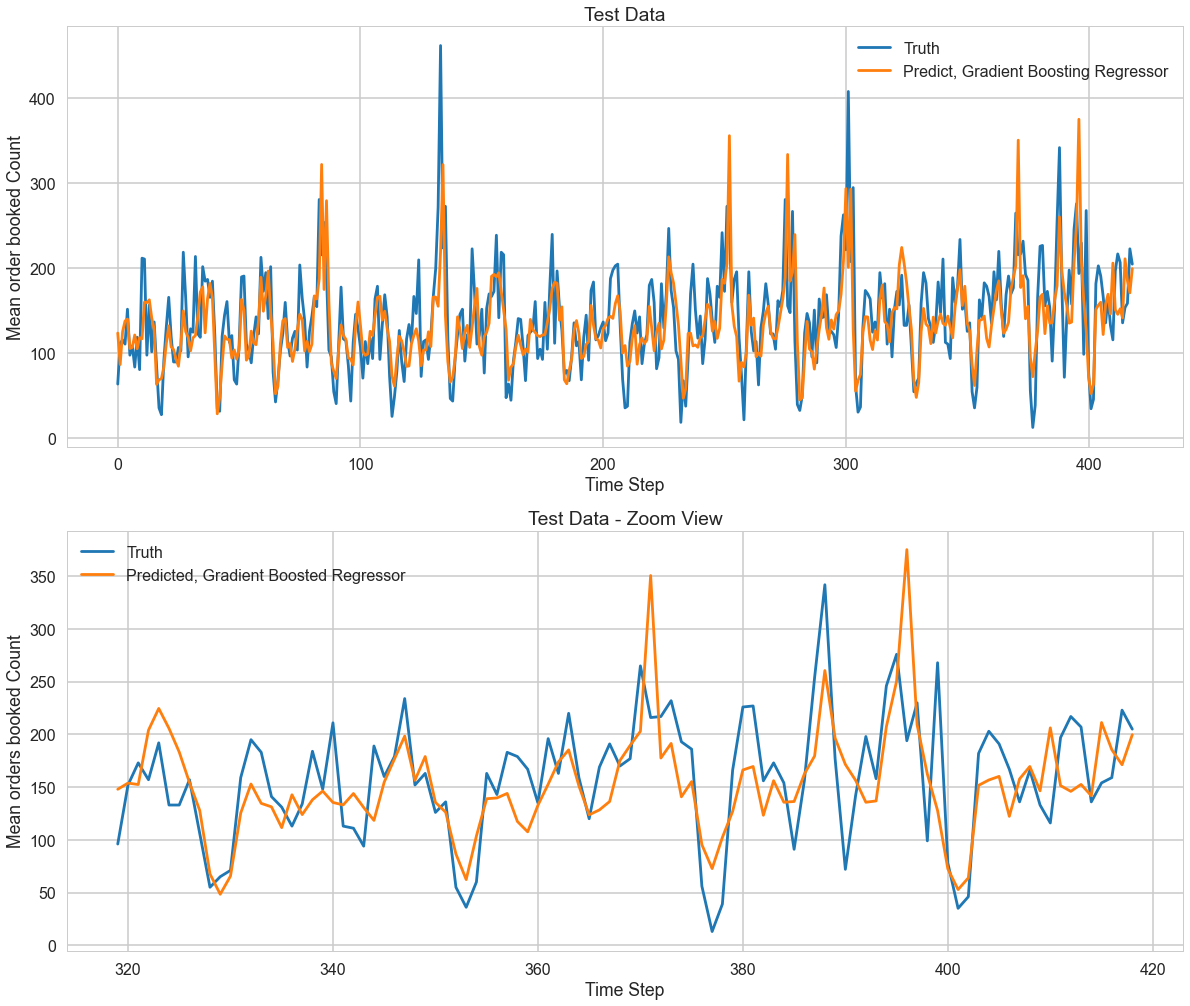

In [21]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,17))
plt.style.use('seaborn-poster')
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='Truth')
plt.plot(predictions['mid'], label='Predict, Gradient Boosting Regressor')
plt.ylabel('Mean order booked Count')
plt.xlabel('Time Step')
plt.title('Test Data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(predictions[0].tail(100), label='Truth')
plt.plot(predictions['mid'].tail(100), label='Predicted, Gradient Boosted Regressor')
plt.ylabel('Mean orders booked Count')
plt.xlabel('Time Step')
plt.title('Test Data - Zoom View')
plt.legend();

In [22]:
# mean_squared_error(y_true, y_pred)
mean_squared_error(y_test, y_pred)

2078.50250395227

In [23]:
xgb_r1 = xgb.XGBRegressor(max_depth = MAX_DEPTH, n_estimators=N_ESTIMATORS)
xgb_r1.fit(X_train, y_train)
y_pred_xgb = xgb_r1.predict(X_test)
predictions['xgb'] = y_pred_xgb

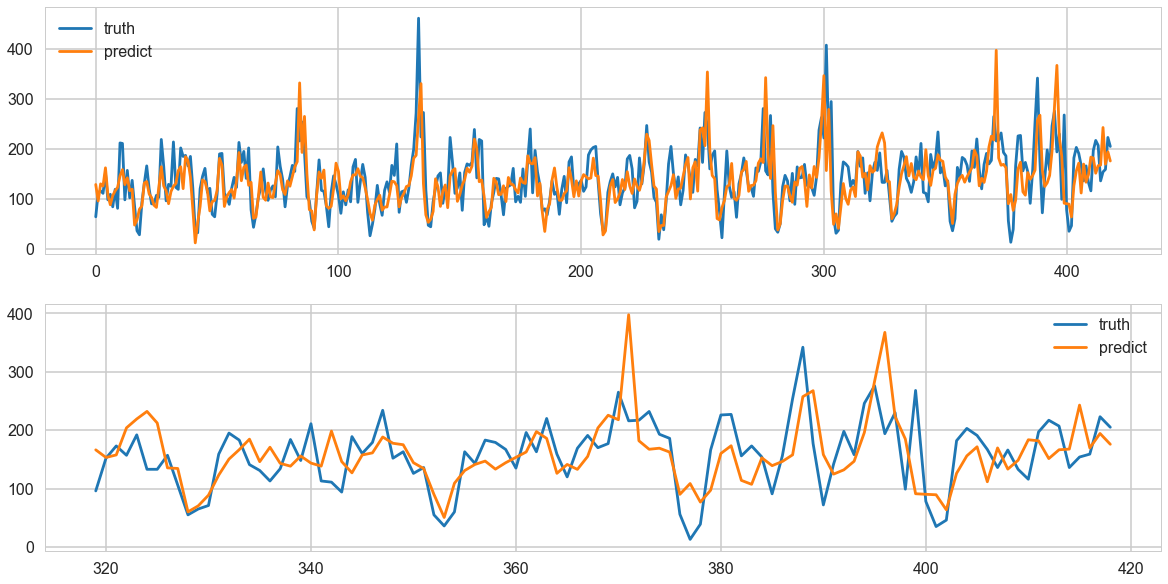

In [24]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='truth')
plt.plot(predictions['xgb'], label='predict')
plt.legend()

plt.subplot(2,1,2)
plt.plot(predictions[0].tail(100), label='truth')
plt.plot(predictions['xgb'].tail(100), label='predict')
plt.legend()

In [25]:
mean_squared_error(y_test, y_pred_xgb) 

2294.243052415626